In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns

import os
import zipfile
import shutil
from glob import glob

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D

In [5]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
link = "https://drive.google.com/file/d/1E9x55KCmpXTK4zyScd-w64RM50eLbezw"
# fluff, id = link.split('d/')
id = link.split('d/')[1]
print (id)

1E9x55KCmpXTK4zyScd-w64RM50eLbezw


In [7]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('waste.zip')  

In [8]:
file_zip = 'waste.zip'
zip_ref = zipfile.ZipFile(file_zip, 'r')
zip_ref.extractall('./waste/')
zip_ref.close()

In [9]:
dir = './waste/'
list_category = sorted(os.listdir(dir))
list_category

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [10]:
# check data for : {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
cardboard_dir = os.path.join(dir,'cardboard')
glass_dir = os.path.join(dir, 'glass')
metal_dir = os.path.join(dir, 'metal')
paper_dir = os.path.join(dir,'paper')
plastic_dir = os.path.join(dir, 'plastic')
trash_dir = os.path.join(dir, 'trash')

print("Cardboard :", len(os.listdir(cardboard_dir)))
print("Glass :", len(os.listdir(glass_dir))) 
print("Metal :", len(os.listdir(metal_dir)))
print("Paper :", len(os.listdir(paper_dir)))
print("Plastic :", len(os.listdir(plastic_dir))) 
print("Trash :", len(os.listdir(trash_dir)))

Cardboard : 403
Glass : 501
Metal : 410
Paper : 594
Plastic : 482
Trash : 137


In [11]:
def is_image(dir, filename, verbose=False):
    name = os.path.join(dir, filename)

    data = open(name,'rb').read(10)

    # check if file is JPG or JPEG
    if data[:3] == b'\xff\xd8\xff':
        if verbose == True:
             print(filename+" is: JPG/JPEG.")
        return True

    # check if file is PNG
    if data[:8] == b'\x89\x50\x4e\x47\x0d\x0a\x1a\x0a':
        if verbose == True:
             print(filename+" is: PNG.")
        return True

    # check if file is GIF
    if data[:6] in [b'\x47\x49\x46\x38\x37\x61', b'\x47\x49\x46\x38\x39\x61']:
        if verbose == True:
             print(filename+" is: GIF.")
        return True

    return False

import os

category_sets = [cardboard_dir, glass_dir, metal_dir, paper_dir, plastic_dir, trash_dir]

# go through all files in desired folder
for image_dir in category_sets:
  for filename in os.listdir(image_dir):
     # check if file is actually an image file
     if is_image(image_dir, filename, verbose=False) == False:
          # if the file is not valid, remove it
          os.remove(os.path.join(image_dir, filename))

Make dataframe with `image` as feature and `target` as target. 
* `image` will be the image's path
* `target` will be the image's target. 
    * `cardboard`: 0
    * `glass`: 1
    * `metal`: 2
    * `paper`: 3
    * `plastic`: 4
    * `trash`: 5

In [12]:
cardboard = glob(cardboard_dir + '/*.jpg') + glob(cardboard_dir + '/*.png')
glass= glob(glass_dir + '/*.jpg') + glob(glass_dir + '/*.png')
metal = glob(metal_dir + '/*.jpg') + glob(metal_dir + '/*.png')
paper = glob(paper_dir + '/*.jpg') + glob(paper_dir + '/*.png')
plastic = glob(plastic_dir + '/*.jpg') + glob(plastic_dir + '/*.png')
trash = glob(trash_dir + '/*.jpg') + glob(trash_dir + '/*.png')

In [13]:
def category_decide(x):
  value = 0
  if 'cardboard' in x:
    value = 0
  elif 'glass' in x:
    value = 1
  elif 'metal' in x:
    value = 2
  elif 'paper' in x:
    value = 3
  elif 'plastic' in x:
    value = 4
  else:
    value = 5
  return value

df = pd.DataFrame(columns=['image', 'target'])
df['image'] = cardboard + glass + metal + paper + plastic + trash
df['target'] = df['image'].apply(lambda x: category_decide(x))
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,image,target
0,./waste/glass/glass32.jpg,1
1,./waste/trash/trash58.jpg,5
2,./waste/glass/glass354.jpg,1
3,./waste/plastic/plastic385.jpg,4
4,./waste/cardboard/cardboard182.jpg,0


In [14]:
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=43, 
    stratify=df['target']
)
val_df, test_df = train_test_split(
    test_df, 
    test_size=0.25, 
    random_state=43, 
    stratify=test_df['target']
)

print("Train: {}".format(train_df.shape))
print("Cardboard  : {}".format(train_df[train_df['target'] == 0].shape[0]))
print("Glass: {}".format(train_df[train_df['target'] == 1].shape[0]))
print("Metal  : {}".format(train_df[train_df['target'] == 2].shape[0]))
print("Paper: {}".format(train_df[train_df['target'] == 3].shape[0]))
print("Plastic  : {}".format(train_df[train_df['target'] == 4].shape[0]))
print("Trash: {}".format(train_df[train_df['target'] == 5].shape[0]))

print("\nVal: {}".format(val_df.shape))
print("Cardboard  : {}".format(val_df[val_df['target'] == 0].shape[0]))
print("Glass: {}".format(val_df[val_df['target'] == 1].shape[0]))
print("Metal  : {}".format(val_df[val_df['target'] == 2].shape[0]))
print("Paper: {}".format(val_df[val_df['target'] == 3].shape[0]))
print("Plastic  : {}".format(val_df[val_df['target'] == 4].shape[0]))
print("Trash: {}".format(val_df[val_df['target'] == 5].shape[0]))

print("\nTest : {}".format(test_df.shape))
print("Cardboard  : {}".format(test_df[test_df['target'] == 0].shape[0]))
print("Glass: {}".format(test_df[test_df['target'] == 1].shape[0]))
print("Metal  : {}".format(test_df[test_df['target'] == 2].shape[0]))
print("Paper: {}".format(test_df[test_df['target'] == 3].shape[0]))
print("Plastic  : {}".format(test_df[test_df['target'] == 4].shape[0]))
print("Trash: {}".format(test_df[test_df['target'] == 5].shape[0]))

Train: (2021, 2)
Cardboard  : 322
Glass: 401
Metal  : 328
Paper: 475
Plastic  : 385
Trash: 110

Val: (379, 2)
Cardboard  : 61
Glass: 75
Metal  : 61
Paper: 89
Plastic  : 73
Trash: 20

Test : (127, 2)
Cardboard  : 20
Glass: 25
Metal  : 21
Paper: 30
Plastic  : 24
Trash: 7


In [15]:
# check a lot of data for list category
for  item in list_category:
  class_dir = os.path.join(dir,item)
  print(item ," : ",len(os.listdir(class_dir)),"images")

cardboard  :  403 images
glass  :  501 images
metal  :  410 images
paper  :  594 images
plastic  :  482 images
trash  :  137 images


In [16]:
# check image (count, size, total)
from PIL import Image
total = 0

for x in list_category:
  dir_cat = os.path.join(dir, x)
  y = len(os.listdir(dir_cat))
  print(x+':', y)
  total = total + y
  
  size = (0,0)
  img_name = os.listdir(dir_cat)
  for i in range(5):
    img_path = os.path.join(dir_cat, img_name[i])
    img = Image.open(img_path)
    
    if size == img.size:
      continue
    else :
      size = img.size
      print('+ size = ',img.size)

print('\nTotal :', total)

cardboard: 403
+ size =  (512, 384)
glass: 501
+ size =  (512, 384)
metal: 410
+ size =  (512, 384)
paper: 594
+ size =  (512, 384)
plastic: 482
+ size =  (512, 384)
trash: 137
+ size =  (512, 384)

Total : 2527


cardboard


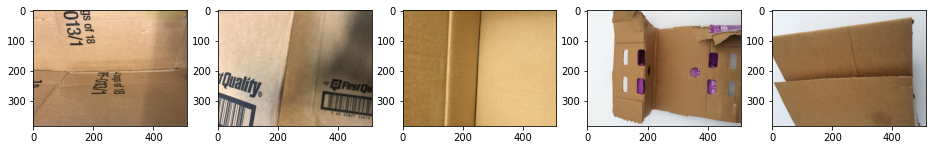

glass


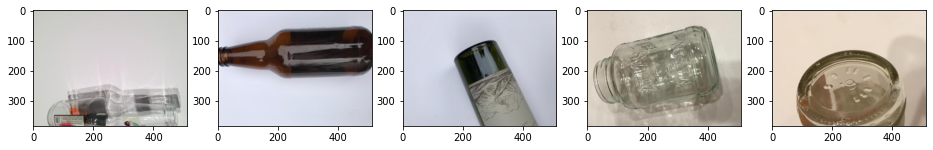

metal


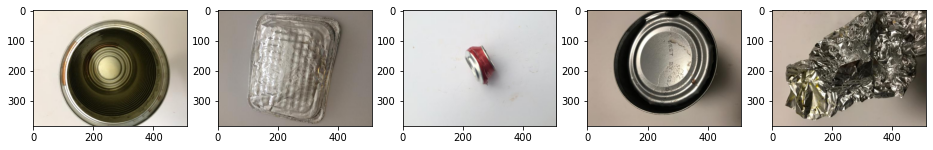

paper


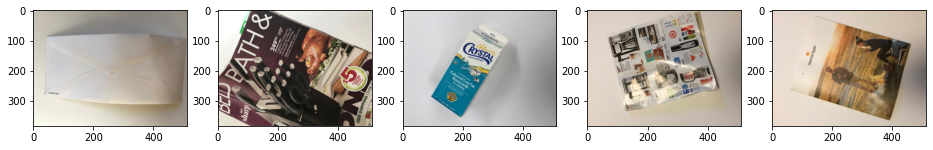

plastic


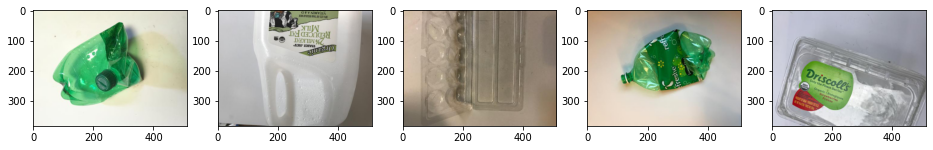

trash


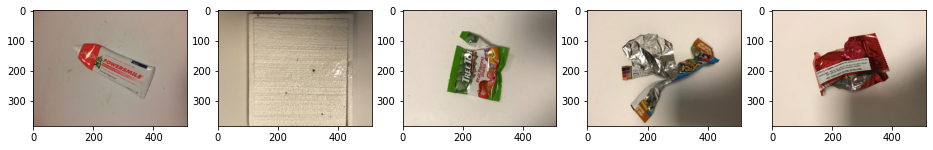

In [17]:
# check images class
for  item in list_category:
  print(item)
  class_dir = os.path.join(dir,item)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(16, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

# Preprocessing Image

Decode Image
1. Normalized, so the range value is 0-1
1. Resized to desired dimension (256 x 256)

Image will be augmented:
1. Random flip left or right
1. Random flip up or down
1. Random brightness
1. Random contrast

In [18]:
dim = 150

def decode_image(filename, label=None, image_size=(dim, dim)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32)  # Convert to float32
    image /= 255.0  # Normalize
    image = tf.image.resize(image, image_size)  #Resize
    
    if label == None:
        return image
    else:
        return image, tf.one_hot(label, depth=len(list_category))

def image_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, lower = 0.3, upper = 0.9)

    if label == None:
        return image
    else: 
        return image, label

# **Image Augmentation**

The number of items to prefetch should be equal to (or possibly higher than) the number of batches consumed by a single training step

In [19]:
AUTO = tf.data.experimental.AUTOTUNE
batch_size = 64

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_df['image'], train_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(image_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(batch_size)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_df['image'], val_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_df['image'], test_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

In [20]:
for img, label in train_dataset.take(1):
    print("Image shape: {}".format(img.numpy().shape))
    print("Label shape: {}".format(label.numpy().shape))

Image shape: (64, 150, 150, 3)
Label shape: (64, 6)


# Train Model 01

In [21]:
import tensorflow as tf
# from tensorflow.keras import applications, optimizers

tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(dim, dim, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(list_category), activation='softmax')
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [23]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.99):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 99%!")
callbacks = myCallback()

In [25]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [26]:
mc = ModelCheckpoint('model_v1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [27]:
history = model.fit(
    train_dataset,
    steps_per_epoch = len(train_df) // batch_size,
    epochs = 100,
    validation_data = val_dataset,
    validation_steps = len(val_df) // batch_size,
    verbose = 1,
    callbacks=[callbacks, es,  mc]
)

Epoch 1/100
31/31 [==============================] - 39s 163ms/step - loss: 1.6789 - accuracy: 0.2717 - val_loss: 1.5895 - val_accuracy: 0.2969

Epoch 00001: val_accuracy improved from -inf to 0.29688, saving model to model_v1.h5
Epoch 2/100
31/31 [==============================] - 5s 166ms/step - loss: 1.6027 - accuracy: 0.3256 - val_loss: 1.4712 - val_accuracy: 0.3938

Epoch 00002: val_accuracy improved from 0.29688 to 0.39375, saving model to model_v1.h5
Epoch 3/100
31/31 [==============================] - 5s 160ms/step - loss: 1.5215 - accuracy: 0.3715 - val_loss: 1.5889 - val_accuracy: 0.3219

Epoch 00003: val_accuracy did not improve from 0.39375
Epoch 4/100
31/31 [==============================] - 5s 151ms/step - loss: 1.5034 - accuracy: 0.3624 - val_loss: 1.3927 - val_accuracy: 0.4563

Epoch 00004: val_accuracy improved from 0.39375 to 0.45625, saving model to model_v1.h5
Epoch 5/100
31/31 [==============================] - 5s 171ms/step - loss: 1.3859 - accuracy: 0.4350 - val_

In [29]:
score_valid = model.evaluate(test_dataset, return_dict=True, verbose=0)

print(score_valid)

{'loss': 1.1003814935684204, 'accuracy': 0.5984252095222473}


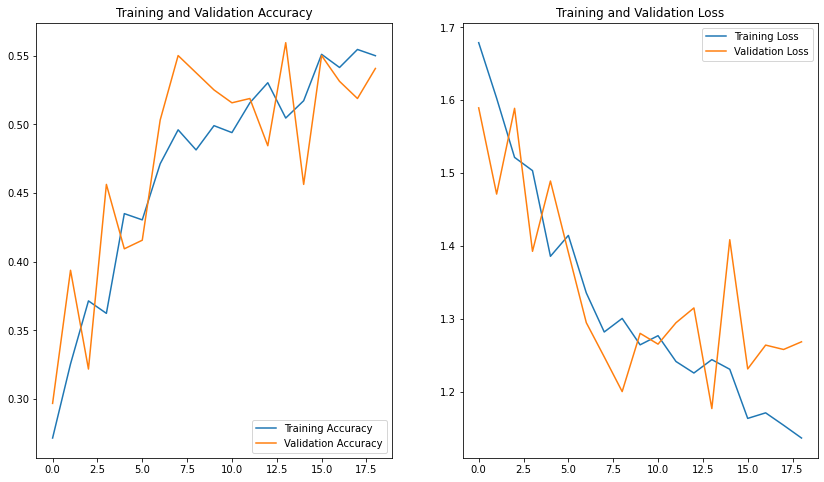

In [33]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs_range   = range(len(acc))
plt.figure(figsize=(14, 8))

# Plot training and validation accuracy per epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Saving cardboard99.jpg to cardboard99.jpg
Glass


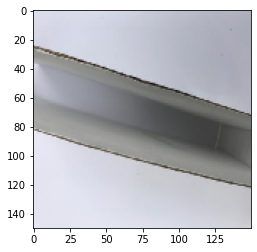

In [34]:
from google.colab import files
from keras.preprocessing import image
 
uploaded = files.upload()
 
for path in uploaded.keys():
  img = image.load_img(path, target_size=(dim,dim))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  images /= 255 # because on train and test image is normalized, on image predict supposed to be too.
  classes = model.predict(images, batch_size=32) # the value is not always 1 and 0 because of probabilities
  predicted_class_indices=np.argmax(classes) # use to check prediction that have higher probabilities

if predicted_class_indices == 0:
    print('Cardboard')
elif predicted_class_indices == 1:
  print('Glass')
elif predicted_class_indices == 2:
  print('Metal')
elif predicted_class_indices == 3:
  print('Paper')
elif predicted_class_indices == 4:
  print('Plastic')
else:
  print('Trash')

In [35]:
classes

array([[1.9086076e-01, 4.4593972e-01, 1.3175106e-01, 1.5125473e-01,
        8.0079593e-02, 1.1406164e-04]], dtype=float32)

In [36]:
try:
    files.download('model_v1.h5')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train Model V2 - Transfer Learning

In [37]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [38]:
dim = pixels

def decode_image(filename, label=None, image_size=(dim, dim)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32)  # Convert to float32
    image /= 255.0  # Normalize
    image = tf.image.resize(image, image_size)  #Resize
    
    if label == None:
        return image
    else:
        return image, tf.one_hot(label, depth=len(list_category))

def image_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, lower = 0.3, upper = 0.9)

    if label == None:
        return image
    else: 
        return image, label

In [39]:
AUTO = tf.data.experimental.AUTOTUNE
batch_size = 128

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_df['image'], train_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(image_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(batch_size)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((val_df['image'], val_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_df['image'], test_df['target']))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

In [40]:
import tensorflow_hub as hub
do_fine_tuning = True #@param {type:"boolean"}

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(list_category), activation='softmax')
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 2,587,462
Trainable params: 2,553,350
Non-trainable params: 34,112
_________________________________________________________________


In [43]:
if do_fine_tuning:
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9)
    feature_extractor.trainable = True
else: 
    feature_extractor.trainable = False
    optimizer = "adam"

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [44]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.99):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 99%!")
callbacks = myCallback()

In [52]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [53]:
mc = ModelCheckpoint('model_v2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [54]:
# fitting model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(train_df) // batch_size,
    epochs = 100,
    validation_data = val_dataset,
    validation_steps = len(val_df) // batch_size,
    verbose = 1,
    callbacks=[callbacks, es, mc]
)

Epoch 1/100
 6/15 [===========>..................] - ETA: 7s - loss: 0.5583 - accuracy: 0.9909WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2064s vs `on_train_batch_end` time: 0.6371s). Check your callbacks.


15/15 [==============================] - 15s 884ms/step - loss: 0.5614 - accuracy: 0.9891 - val_loss: 0.9061 - val_accuracy: 0.8750

Epoch 00001: val_accuracy improved from -inf to 0.87500, saving model to model_v2.h5
Epoch 2/100
15/15 [==============================] - 13s 899ms/step - loss: 0.5422 - accuracy: 0.9932 - val_loss: 0.9066 - val_accuracy: 0.8750

Epoch 00002: val_accuracy did not improve from 0.87500
Epoch 3/100
15/15 [==============================] - 13s 891ms/step - loss: 0.5458 - accuracy: 0.9932 - val_loss: 0.9012 - val_accuracy: 0.8750

Epoch 00003: val_accuracy did not improve from 0.87500
Epoch 4/100
15/15 [==============================] - 12s 830ms/step - loss: 0.5405 - accuracy: 0.9917 - val_loss: 0.9061 - val_accuracy: 0.8906

Epoch 00004: val_accuracy improved from 0.87500 to 0.89062, saving model to model_v2.h5
Epoch 5/100
15/15 [==============================] - 13s 876ms/step - loss: 0.5365 - accuracy: 0.9917 - val_loss: 0.8903 - val_accuracy: 0.8906

Epoc

In [55]:
score_valid = model.evaluate(test_dataset, return_dict=True, verbose=0)

print(score_valid)

{'loss': 0.8462960720062256, 'accuracy': 0.9212598204612732}


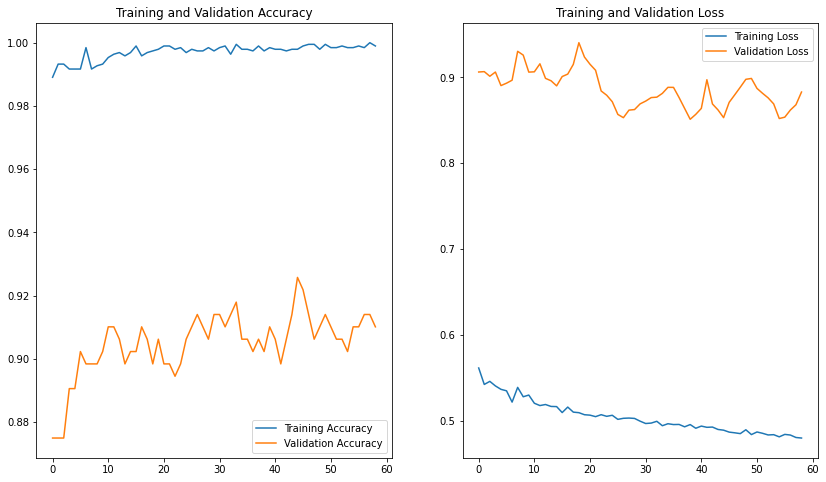

In [56]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs_range   = range(len(acc))
plt.figure(figsize=(14, 8))

# Plot training and validation accuracy per epoch
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

Saving cardboard80.jpg to cardboard80.jpg
Cardboard


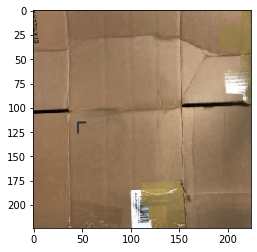

In [57]:
from google.colab import files
from keras.preprocessing import image
 
uploaded = files.upload()
 
for path in uploaded.keys():
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  images /= 255 # because on train and test image is normalized, on image predict supposed to be too.
  classes = model.predict(images, batch_size) # the value is not always 1 and 0 because of probabilities
  predicted_class_indices=np.argmax(classes) # use to check prediction that have higher probabilities

if predicted_class_indices == 0:
    print('Cardboard')
elif predicted_class_indices == 1:
  print('Glass')
elif predicted_class_indices == 2:
  print('Metal')
elif predicted_class_indices == 3:
  print('Paper')
elif predicted_class_indices == 4:
  print('Plastic')
else:
  print('Trash')

In [58]:
classes

array([[9.9999940e-01, 2.2238485e-08, 1.9883906e-08, 2.1491308e-08,
        5.5339530e-08, 5.7862547e-07]], dtype=float32)

In [59]:
try:
    files.download('model_v2.h5')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>